# Hamon Evaporation Estimation

The goal here is to take in the csv just as it is, and calculate the evaporation values for each month in the dataset

In [25]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
hollis = pd.read_csv("Hollis.csv")
hollis.head()

,Date / Time,AirTC (Avg),RH,SlrkW (Avg),SlrjJ (Tot),WS ms (Avg),Wind Dir,T108 C (Avg),HBr3W,Rain mm (Tot)
0,7/17/2014 15:30,26.94,67.85,0.412,609.3776,1.667,335.900,31.21,221.5,0.0
1,7/17/2014 16:00,26.89,69.88,0.387,696.9075,1.618,59.220,31.45,221.4,0.0
2,7/17/2014 16:30,26.45,73.05,0.154,277.9549,1.753,52.930,31.25,221.3,0.0
3,7/17/2014 17:00,26.27,73.78,0.183,328.9092,1.879,2.172,30.91,220.9,0.0
4,7/17/2014 17:30,25.95,75.34,0.060,107.9211,1.944,33.750,30.47,220.8,0.0


A few things to note. Readings are taken every 30 minutes, and so that obviously needs to get cut down to days. The Hamon evaporation method only takes into account the sunshine hours and daily average temperature, so I could probably get rid of the other columns for now. 

In [3]:
df = hollis[["Date / Time", "T108 C (Avg)"]]    #Using pan temp since air temp has some weird values
df.columns = ['date', 'temp']
df.head()

,date,temp
0,7/17/2014 15:30,31.21
1,7/17/2014 16:00,31.45
2,7/17/2014 16:30,31.25
3,7/17/2014 17:00,30.91
4,7/17/2014 17:30,30.47


In [4]:
df.describe()

,temp
count,20054.000000
mean,27.002141
std,2.911931
min,20.460000
25%,24.770000
50%,26.440000
75%,28.960000
max,37.270000


Ok I would like to only have daily data. First I think I need to convert the first column to a date object. Check for any nulls first just in case

In [5]:
any_nan = df.columns[df.isnull().any()]
len(list(any_nan))

2

To remove the nulls

In [6]:
df.dropna(axis=0, subset=["temp"], inplace=True)
any_nan = df.columns[df.isnull().any()]
len(list(any_nan))

C:\Users\lum1679\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0

In [7]:
df["date"] = pd.to_datetime(df.date).dt.date
df.head()

C:\Users\lum1679\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,temp
0,2014-07-17,31.21
1,2014-07-17,31.45
2,2014-07-17,31.25
3,2014-07-17,30.91
4,2014-07-17,30.47


In [8]:
df = df.groupby('date', as_index=False, sort=False)['temp'].mean()
df.head()

,date,temp
0,2014-07-17,28.745294
1,2014-07-18,24.944583
2,2014-07-19,25.877708
3,2014-07-20,25.772083
4,2014-07-21,27.385000


In [9]:
df['date'] = pd.to_datetime(df.date)

## Solar Declination 

Looks like we now have the average temperature of each day. Now to start the formulas. First up is the solar declination delta, given by: 

\begin{equation*}
\delta = 0.4093\sin\left({2\pi\over365}J-1.405\right)
\end{equation*}

where J is the Julian Day, or the number of days from the start of the year in other words. So lets make a column with the Julian day

In [10]:
df['julian'] = df['date'].dt.dayofyear
df.head()

,date,temp,julian
0,2014-07-17,28.745294,198
1,2014-07-18,24.944583,199
2,2014-07-19,25.877708,200
3,2014-07-20,25.772083,201
4,2014-07-21,27.385000,202


In [11]:
df['delta'] = df['julian'].apply(lambda x: 0.4093*math.sin(2*math.pi*x/365-1.405))
df.head()

,date,temp,julian,delta
0,2014-07-17,28.745294,198,0.371592
1,2014-07-18,24.944583,199,0.368583
2,2014-07-19,25.877708,200,0.365465
3,2014-07-20,25.772083,201,0.362239
4,2014-07-21,27.385000,202,0.358905


## Sunset hour angle

The formula is:

\begin{equation*}
\omega = arccos(-tan\phi(tan\delta))
\end{equation*}

where phi is the latitude of the resevoir in decimal degrees. For Hollis reservoir it is approximately 10.690243. Be sure to convert to radians in the formula

In [12]:
phi = 10.690243    #latitude of reservoir in decimal degrees

In [13]:
df['sunset'] = df['delta'].apply(lambda x: math.acos(-math.radians(math.tan(phi))*math.tan(x)))
df.head()

,date,temp,julian,delta,sunset
0,2014-07-17,28.745294,198,0.371592,1.592377
1,2014-07-18,24.944583,199,0.368583,1.592185
2,2014-07-19,25.877708,200,0.365465,1.591987
3,2014-07-20,25.772083,201,0.362239,1.591783
4,2014-07-21,27.385000,202,0.358905,1.591572


## Maximum daylight hours

Maximum daylight hours D, is given by:

\begin{equation*}
D = {24\omega\over\pi}
\end{equation*}

In [14]:
df['daylight'] = df['sunset'].apply(lambda x: 24*x/math.pi)
df.head()

,date,temp,julian,delta,sunset,daylight
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712


## Saturation Vapour Pressure

In Kilopascals

\begin{equation*}
e_s = 0.6108exp{\left(17.27T_a \over 237.3 + T_a\right)}
\end{equation*}

In [15]:
df['vpressure'] = df['temp'].apply(lambda x: 0.6108*math.exp((17.27*x)/(237.3+x)))
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667


## Celsius to Kelvins

This doesn't need an explanation

In [16]:
df['kelvin'] = df['temp']+273.15
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000


## Saturation Vapour Density

\begin{equation*}
SVD = 2166.74\left(e_s\over T_a\right)
\end{equation*}

SVD is in grams per cubic meter and T<sub>a</sub> is in kelvins

In [17]:
df['SVD'] = 2166.74*(df['vpressure']/df['kelvin'])
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin,SVD
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294,28.328777
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583,22.949517
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708,24.181302
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083,24.039079
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000,26.291043


## Evaporation

\begin{equation*}
E = 0.55\left(D\over 12\right)^2 \left(SVD\over 100\right)
\end{equation*}

where E is in inches per day. I don't know what's with all these unit changes. I'll convert it to mm one time

In [18]:
df['E'] = 0.55*((df['daylight']/12)**2)*(df['SVD']/100)*25.4
df.head()

,date,temp,julian,delta,sunset,daylight,vpressure,kelvin,SVD,E
0,2014-07-17,28.745294,198,0.371592,1.592377,12.164865,3.947093,301.895294,28.328777,4.067020
1,2014-07-18,24.944583,199,0.368583,1.592185,12.163401,3.157336,298.094583,22.949517,3.293954
2,2014-07-19,25.877708,200,0.365465,1.591987,12.161886,3.337216,299.027708,24.181302,3.469888
3,2014-07-20,25.772083,201,0.362239,1.591783,12.160323,3.316416,298.922083,24.039079,3.448593
4,2014-07-21,27.385000,202,0.358905,1.591572,12.158712,3.646667,300.535000,26.291043,3.770656


Now we have estimated daily evaporation values. This should maybe be saved to a file

## Monthly Evaporation

In [19]:
month_df = df[['date', 'E']]
month_df.set_index('date', inplace=True)
month_df.head()

,E
date,
2014-07-17,4.067020
2014-07-18,3.293954
2014-07-19,3.469888
2014-07-20,3.448593
2014-07-21,3.770656


In [20]:
month_df_sum = month_df.groupby(pd.TimeGrouper("M")).sum()
month_df_sum.head()

,E
date,
2014-07-31,56.776961
2014-08-31,118.274630
2014-09-30,3.686294
2014-10-31,92.720948
2014-11-30,98.963824


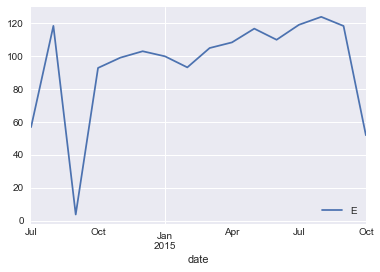

In [30]:
month_df_sum.plot()

We have the problem of incomplete months to deal with. Maybe find the mean and multiply by the number of days in the month?

In [21]:
month_df_avg = month_df.groupby(pd.TimeGrouper("M")).mean()
month_df_avg.head()

,E
date,
2014-07-31,3.785131
2014-08-31,3.815311
2014-09-30,3.686294
2014-10-31,3.708838
2014-11-30,3.298794


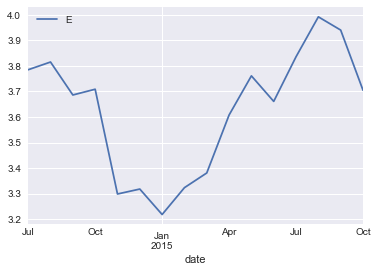

In [29]:
month_df_avg.plot()

## Comparison

How does this compare with the actual recorded loss from the evaporation pan? Let's find out. We want the date, water level, and rainfall columns

In [23]:
loss_df = hollis[["Date / Time", "HBr3W", "Rain mm (Tot)"]]    
loss_df.columns = ['date', 'level', 'rainfall']
loss_df.dropna(axis=0, subset=['rainfall'], inplace=True)
loss_df['date'] = pd.to_datetime(loss_df.date).dt.date
loss_df.head()

C:\Users\lum1679\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lum1679\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date,level,rainfall
0,2014-07-17,221.5,0.0
1,2014-07-17,221.4,0.0
2,2014-07-17,221.3,0.0
3,2014-07-17,220.9,0.0
4,2014-07-17,220.8,0.0


Need to somehow get the daily change in water level

In [24]:
loss_df = loss_df.groupby(loss_df.index)['rainfall'].sum()
loss_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: rainfall, dtype: float64